In [ ]:
!pip install yfinance -q
!pip install plotly -q

     |████████████████████████████████| 62 kB 1.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf

from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler



import statsmodels
from math import sqrt
import numpy as np
from numpy import mean
from numpy import median
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import  Holt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as mpl

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

print(mpl.__version__)  
print(sns.__version__)
%matplotlib inline

3.2.2
0.11.2


In [ ]:
df = pd.DataFrame(yf.Ticker('^GSPC').history(period="max"))
df['date'] = df.index
sp500Month = df.Close
sp500Month.index = pd.to_datetime(df.index)
sp500Month = sp500Month.resample('1M').mean()

In [ ]:
train_size = int(len(sp500Month) * 0.9) 
train, test = train_test_split(sp500Month, train_size=train_size, shuffle=False)

In [ ]:
scaler = StandardScaler()
train = pd.Series(scaler.fit_transform(train.values.reshape(-1, 1))[:, 0], index=train.index)
test = pd.Series(scaler.transform(test.values.reshape(-1, 1))[:, 0], index=test.index)

In [ ]:
close_data = sp500Month.values.reshape((-1,1))

split_percent = 0.95
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = sp500Month.index[:split]
date_test = sp500Month.index[split:]

print(len(close_train))
print(len(close_test))

828
44


In [ ]:
train_mean = train.mean()
train_std = train.std()

train_df = (train - train_mean) / train_std 
test_df = (test - train_mean) / train_std

In [ ]:
look_back = 12

train_generator = TimeseriesGenerator(train_df, train_df, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(test_df, test_df, length=look_back, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(look_back,1),return_sequences=True))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='mse')

num_epochs = 10
model.fit(train_generator, epochs=num_epochs,  batch_size=128, verbose=1, validation_data=test_generator)

Epoch 1/10
39/39 [==============================] - 5s 73ms/step - loss: 0.4613 - val_loss: 8.7422
Epoch 2/10
39/39 [==============================] - 1s 33ms/step - loss: 0.2556 - val_loss: 22.2477
Epoch 3/10
39/39 [==============================] - 1s 33ms/step - loss: 0.1606 - val_loss: 9.2223
Epoch 4/10
39/39 [==============================] - 1s 33ms/step - loss: 0.1350 - val_loss: 5.5822
Epoch 5/10
39/39 [==============================] - 1s 32ms/step - loss: 0.1161 - val_loss: 3.6705
Epoch 6/10
39/39 [==============================] - 1s 32ms/step - loss: 0.1012 - val_loss: 2.8339
Epoch 7/10
39/39 [==============================] - 1s 34ms/step - loss: 0.0899 - val_loss: 2.2822
Epoch 8/10
39/39 [==============================] - 1s 32ms/step - loss: 0.0815 - val_loss: 2.1208
Epoch 9/10
39/39 [==============================] - 1s 32ms/step - loss: 0.0721 - val_loss: 1.5873
Epoch 10/10
39/39 [==============================] - 1s 33ms/step - loss: 0.0691 - val_loss: 1.8886


In [ ]:
pd.DataFrame(model.history.history['loss'])

,0
0,0.461263
1,0.255571
2,0.160605
3,0.134970
4,0.116109
5,0.101194
6,0.089949
7,0.081543
8,0.072106
9,0.069136


In [ ]:
prediction = model.predict(test_generator)

close_train = train.values.reshape((-1))
close_test = test.values.reshape((-1))
prediction = prediction.reshape((-1))


In [ ]:
prediction = np.array(prediction)

In [ ]:
len(date_test), len(prediction)

(44, 912)

In [ ]:
import plotly.graph_objs as go

In [ ]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Trening podaci'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Predikcija'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Test podaci'
)
layout = go.Layout(
    title = "S&P 500",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [ ]:
close_data = close_data.reshape((-1))

In [ ]:
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = sp500Month.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [ ]:
num_prediction = 24
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
forecast_df = pd.DataFrame(forecast, index=forecast_dates)

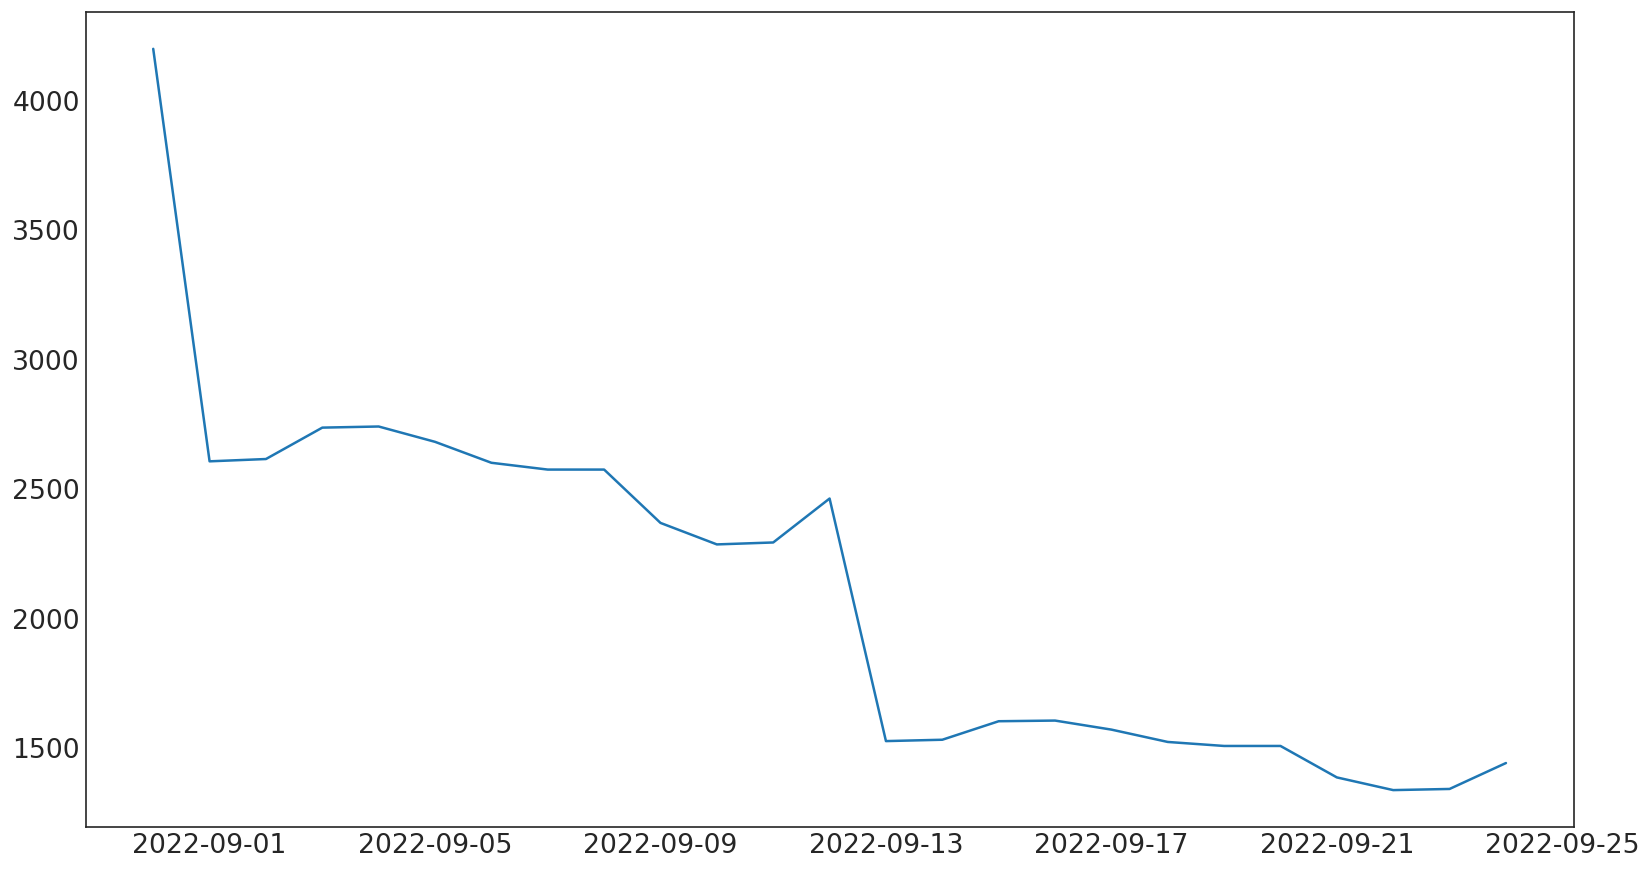

In [ ]:
fig, ax  = plt.subplots(figsize=(16,9), dpi=120)
ax.plot(forecast_df, label="Trening")

# ***10 godisnji podaci***

In [ ]:
twentyYrs = 252 * 20
twentyYrsData = sp500['Close']
twentyYrsData = twentyYrsData[-twentyYrs:]

close_data = twentyYrsData.values
close_data = close_data.reshape((-1,1))

split_percent = 0.90
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = twentyYrsData.index[:split]
date_test = twentyYrsData.index[split:]

print(len(close_train))
print(len(close_test))

4536
504


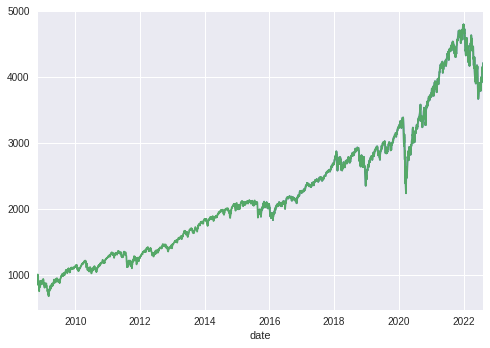

In [ ]:
tenYrsData.plot()
twentyYrsData.plot()

In [ ]:
look_back = 21

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

### **Treniranje LSTM modela**

In [ ]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(look_back,1),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu', ))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
39/39 [==============================] - 6s 84ms/step - loss: 0.6213
Epoch 2/20
39/39 [==============================] - 3s 86ms/step - loss: 0.3588
Epoch 3/20
39/39 [==============================] - 3s 87ms/step - loss: 0.0510
Epoch 4/20
39/39 [==============================] - 3s 85ms/step - loss: 0.0616
Epoch 5/20
39/39 [==============================] - 3s 86ms/step - loss: 0.0481
Epoch 6/20
39/39 [==============================] - 3s 85ms/step - loss: 0.0548
Epoch 7/20
39/39 [==============================] - 3s 86ms/step - loss: 0.0415
Epoch 8/20
39/39 [==============================] - 3s 86ms/step - loss: 0.0504
Epoch 9/20
39/39 [==============================] - 5s 137ms/step - loss: 0.0905
Epoch 10/20
39/39 [==============================] - 3s 87ms/step - loss: 0.0752
Epoch 11/20
39/39 [==============================] - 3s 87ms/step - loss: 0.0439
Epoch 12/20
39/39 [==============================] - 3s 88ms/step - loss: 0.0501
Epoch 13/20
39/39 [=================

In [ ]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [ ]:
prediction = np.array(prediction)

In [ ]:
len(date_test), len(prediction)

(88, 73)

In [ ]:
import plotly.graph_objs as go

In [ ]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Trening podaci'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Predikcija'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Test podaci'
)
layout = go.Layout(
    title = "S&P 500",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [ ]:
close_data = close_data.reshape((-1))

In [ ]:
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = sp500.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [ ]:
num_prediction = 300
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Foracasted'
)
layout = go.Layout(
    title = "S&P 500",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()


## **Drugi LSTM model**

In [ ]:
from tensorflow.keras import layers

In [ ]:
sp500Month = pd.DataFrame(sp500Month)

In [ ]:
HORIZON = 1

WINDOW_SIZE = 7

sp500_prices_windowed = sp500Month.copy()

for i in range(WINDOW_SIZE): 
  sp500_prices_windowed[f"Price+{i+1}"] = sp500Month["Close"].shift(periods=i+1)

sp500_prices_windowed.head(10)

,Close,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
1950-01-31,16.875714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02-28,17.192778,16.875714,NaN,NaN,NaN,NaN,NaN,NaN
1950-03-31,17.346522,17.192778,16.875714,NaN,NaN,NaN,NaN,NaN
1950-04-30,17.845263,17.346522,17.192778,16.875714,NaN,NaN,NaN,NaN
1950-05-31,18.434546,17.845263,17.346522,17.192778,16.875714,NaN,NaN,NaN
1950-06-30,18.736818,18.434546,17.845263,17.346522,17.192778,16.875714,NaN,NaN
1950-07-31,17.384000,18.736818,18.434546,17.845263,17.346522,17.192778,16.875714,NaN
1950-08-31,18.433044,17.384000,18.736818,18.434546,17.845263,17.346522,17.192778,16.875714
1950-09-30,19.084500,18.433044,17.384000,18.736818,18.434546,17.845263,17.346522,17.192778


In [ ]:
X_all = sp500_prices_windowed.drop(["Close"], axis=1).dropna().to_numpy()
y_all = sp500_prices_windowed.dropna()["Close"].to_numpy()

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024 
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

neural_model = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

neural_model.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

neural_model.fit(dataset_all,
            epochs=100,
            verbose=0) 

In [ ]:
dir(neural_model.history)


In [ ]:
neural_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f92d3615850>>

In [ ]:
INTO_FUTURE = 36   

In [ ]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:

  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Prognozna na osnovu: \n {last_window} -> prognoza: {tf.squeeze(future_pred).numpy()}\n")
    
    future_forecast.append(tf.squeeze(future_pred).numpy())

    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=neural_model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
def get_future_dates(start_date, into_future, offset=1):

  start_date = start_date + np.timedelta64(offset, "M") 
  end_date = start_date + np.timedelta64(into_future, "M")
  return np.arange(start_date, end_date, dtype="datetime64[M]") 

In [ ]:
last_timestep = sp500Month.index[-1]
last_timestep

Timestamp('2022-08-31 00:00:00', freq='M')

In [ ]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) 
  plt.grid(True)

In [ ]:
next_time_steps_s = np.insert(next_time_steps, 0, last_timestep)
future_forecast_s = np.insert(future_forecast, 0, sp500Month.Close[-1])
next_time_steps_s, future_forecast_s

In [ ]:
len(next_time_steps_s), len(future_forecast_s)

(37, 37)

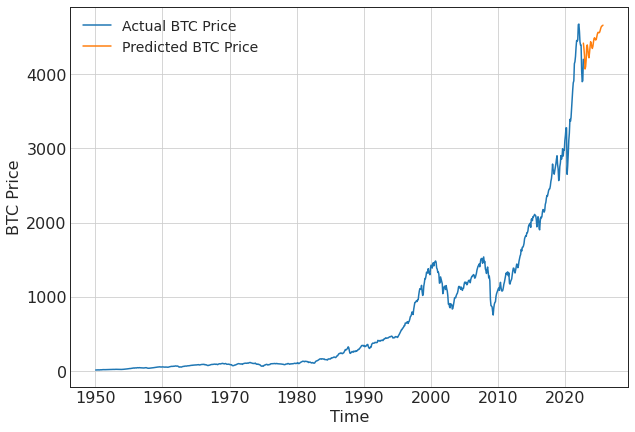

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(sp500Month.index, sp500Month.Close,  format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

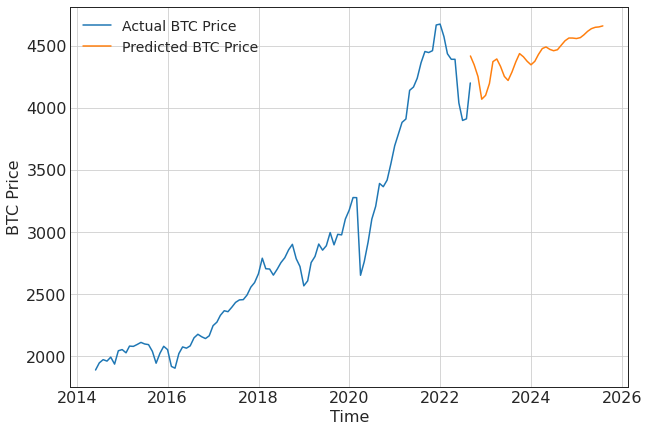

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(sp500Month.index[-100:], sp500Month.Close[-100:],  format="-", label="Istorijska Vrednost")
plot_time_series(next_time_steps, future_forecast, format="-", label="Prognozirana vrednost")

(array([734503., 735234., 735964., 736695., 737425., 738156., 738886.,
        739617.]), <a list of 8 Text major ticklabel objects>)

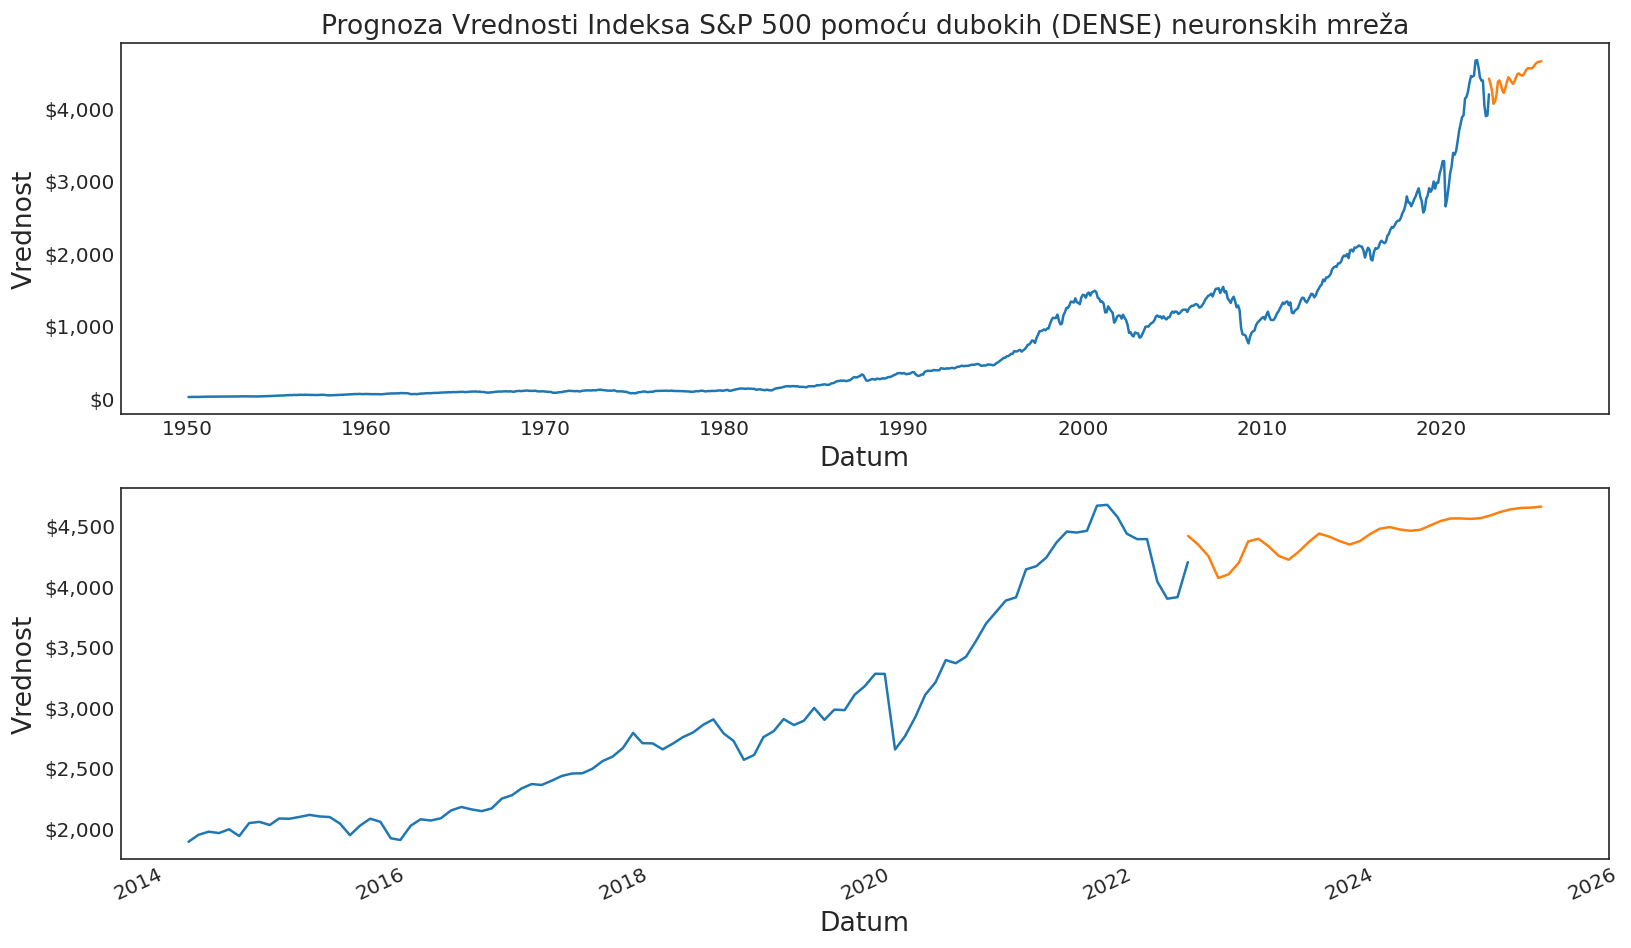

In [ ]:
fig, (ax1, ax2)  = plt.subplots(2,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.2)

ax1.plot(sp500Month.index, sp500Month.Close, label="Test")
ax1.plot(next_time_steps, future_forecast, label="Trening")

ax2.plot(sp500Month.index[-100:], sp500Month.Close[-100:])
ax2.plot(next_time_steps, future_forecast)


ax1.set_title("Prognoza Vrednosti Indeksa S&P 500 pomoću dubokih (DENSE) neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("Vrednost")

ax2.set_xlabel("Datum")
ax2.set_ylabel("Vrednost")

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

In [ ]:
future_forecast

### **Treci Model**

In [ ]:
HORIZON = 1
WINDOW_SIZE = 5

complete_data = sp500Month.copy()

for i in range(WINDOW_SIZE): 
  complete_data[f"Price+{i+1}"] = sp500Month["Close"].shift(periods=i+1)

complete_data.tail(10)

,Close,Price+1,Price+2,Price+3,Price+4,Price+5
Date,,,,,,
2021-11-30,4667.386649,4460.707078,4445.543318,4453.965931,4363.712798,4238.489546
2021-12-31,4674.772772,4667.386649,4460.707078,4445.543318,4453.965931,4363.712798
2022-01-31,4573.815454,4674.772772,4667.386649,4460.707078,4445.543318,4453.965931
2022-02-28,4435.980494,4573.815454,4674.772772,4667.386649,4460.707078,4445.543318
2022-03-31,4391.265264,4435.980494,4573.815454,4674.772772,4667.386649,4460.707078
2022-04-30,4391.295996,4391.265264,4435.980494,4573.815454,4674.772772,4667.386649
2022-05-31,4040.360003,4391.295996,4391.265264,4435.980494,4573.815454,4674.772772
2022-06-30,3898.946684,4040.360003,4391.295996,4391.265264,4435.980494,4573.815454
2022-07-31,3911.729492,3898.946684,4040.360003,4391.295996,4391.265264,4435.980494


In [ ]:
train, test = train_test_split(complete_data, test_size=0.1, shuffle=False)

In [ ]:
X_test = test.drop(["Close"], axis=1).dropna().to_numpy() 
y_test = test.dropna()["Close"].to_numpy()

features_dataset_test = tf.data.Dataset.from_tensor_slices(X_test)
labels_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)

dataset_test = tf.data.Dataset.zip((features_dataset_test, labels_dataset_test))

BATCH_SIZE = 1024 
dataset_test = dataset_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
X_all = train.drop(["Close"], axis=1).dropna().to_numpy() 
y_all = train.dropna()["Close"].to_numpy()

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024 
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=1000,
            verbose=0, validation_data=(X_test, y_test)
) 

**Plotovanje vrednosti funckije gubitka**

In [ ]:
import matplotlib.ticker as plticker

fig, (ax1)  = plt.subplots(1,1,figsize=(30,10), dpi=120)

loss = pd.DataFrame(model_9.history.history['loss'])
val_loss = pd.DataFrame(model_9.history.history['val_loss'])


ax1.plot(loss, label="loss")
ax1.plot(val_loss, label="val_loss")

ax1.legend(['loss', 'val_loss'])

ax1.set_title("Greška prognoze tokom treniranja neuronskih mreža")
ax1.set_xlabel("Epohe")
ax1.set_ylabel("Greska")


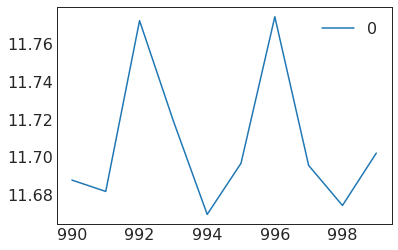

In [ ]:
loss[-10:].plot()

In [ ]:
INTO_FUTURE = len(test)

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
last_timestep = train.index[-1]
last_timestep

In [ ]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
next_time_steps_s = np.insert(next_time_steps, 0, last_timestep)
future_forecast_s = np.insert(future_forecast, 0, sp500Month.Close[-1])


In [ ]:
len(next_time_steps_s), len(future_forecast_s)

(89, 89)

(array([732312., 733042., 733773., 734503., 735234., 735964., 736695.,
        737425., 738156., 738886.]),
 <a list of 10 Text major ticklabel objects>)

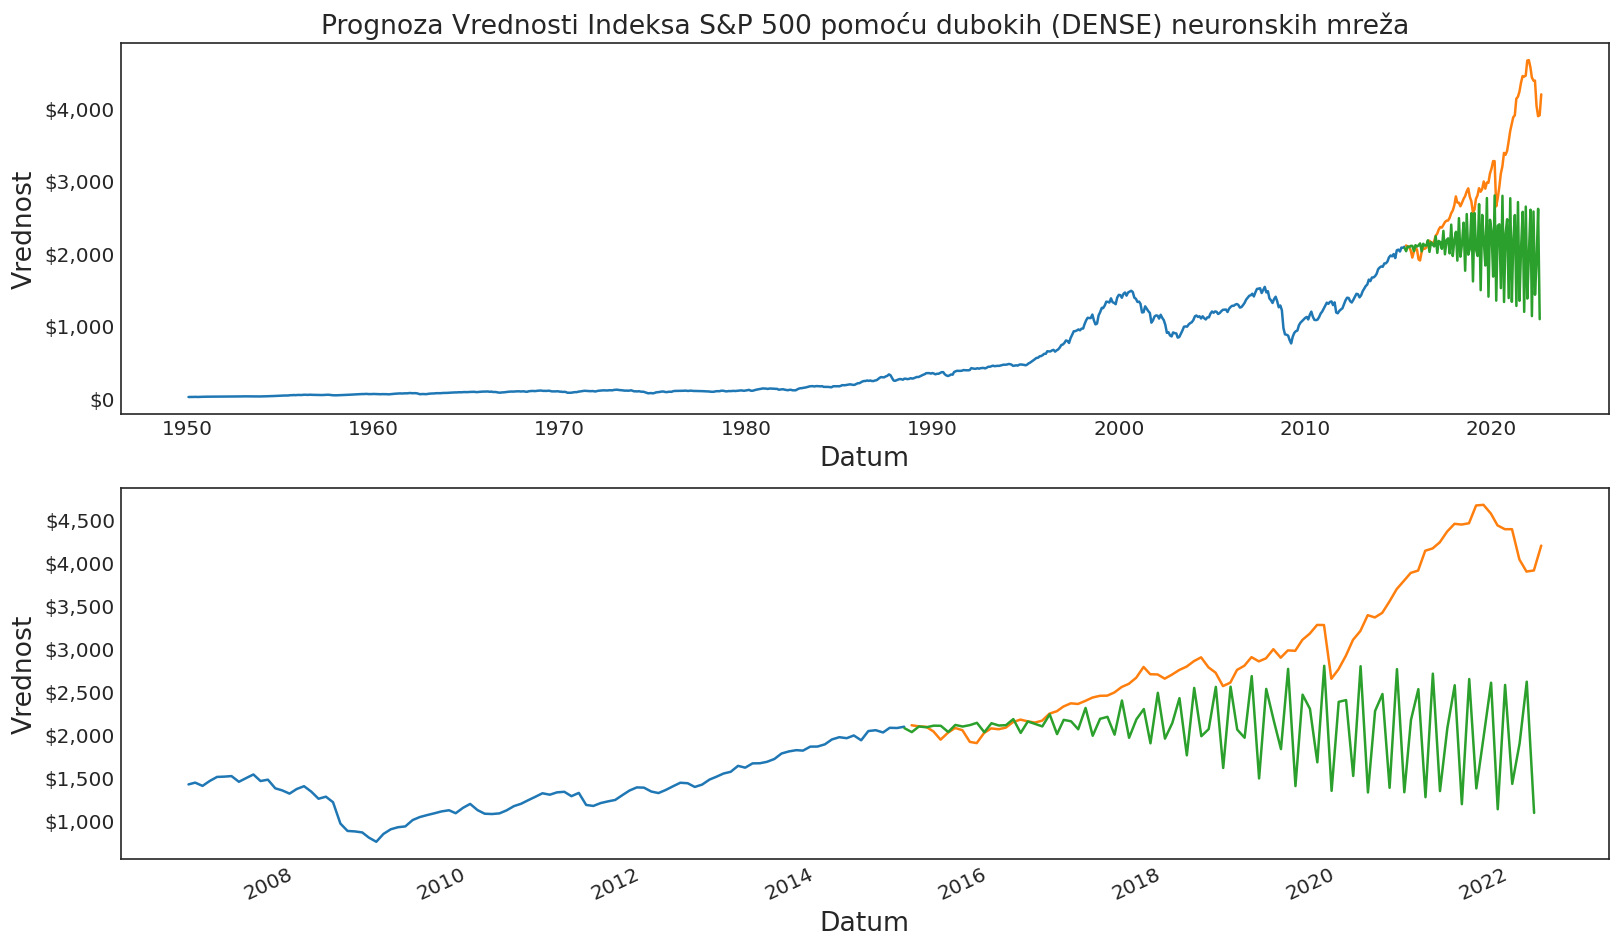

In [ ]:
fig, (ax1, ax2)  = plt.subplots(2,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.2)

ax1.plot(train.index, train.Close)
ax1.plot(test.index, test.Close)
ax1.plot(next_time_steps, future_forecast)

ax2.plot(train.index[-100:], train.Close[-100:])
ax2.plot(test.index, test.Close)
ax2.plot(next_time_steps, future_forecast)


ax1.set_title("Prognoza Vrednosti Indeksa S&P 500 pomoću dubokih (DENSE) neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("Vrednost")

ax2.set_xlabel("Datum")
ax2.set_ylabel("Vrednost")

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

In [ ]:
mse = mean_squared_error(test, future_forecast)
print('MSE: '+str(mse))

mae = mean_absolute_error(test, future_forecast)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(test, future_forecast))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(test, future_forecast)
print('MAPE: '+str(mape))

ValueError: ignored

### **Cetvrti model**

In [ ]:
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
x = layers.LSTM(128, activation="relu", return_sequences=True)(x) 
x = layers.LSTM(128, activation="relu", return_sequences=True)(x) 


x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_lstm.compile(optimizer='adam', loss='mse')

num_epochs = 2000
model_lstm.fit(dataset_all, epochs=num_epochs, verbose=1)

In [ ]:
INTO_FUTURE = len(test)   

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_lstm,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
next_time_steps_s = np.insert(next_time_steps, 0, last_timestep)
future_forecast_s = np.insert(future_forecast, 0, sp500Month.Close[-1])
next_time_steps_s, future_forecast_s

In [ ]:
len(next_time_steps_s), len(future_forecast_s)

(89, 89)

(array([732312., 733042., 733773., 734503., 735234., 735964., 736695.,
        737425., 738156., 738886.]),
 <a list of 10 Text major ticklabel objects>)

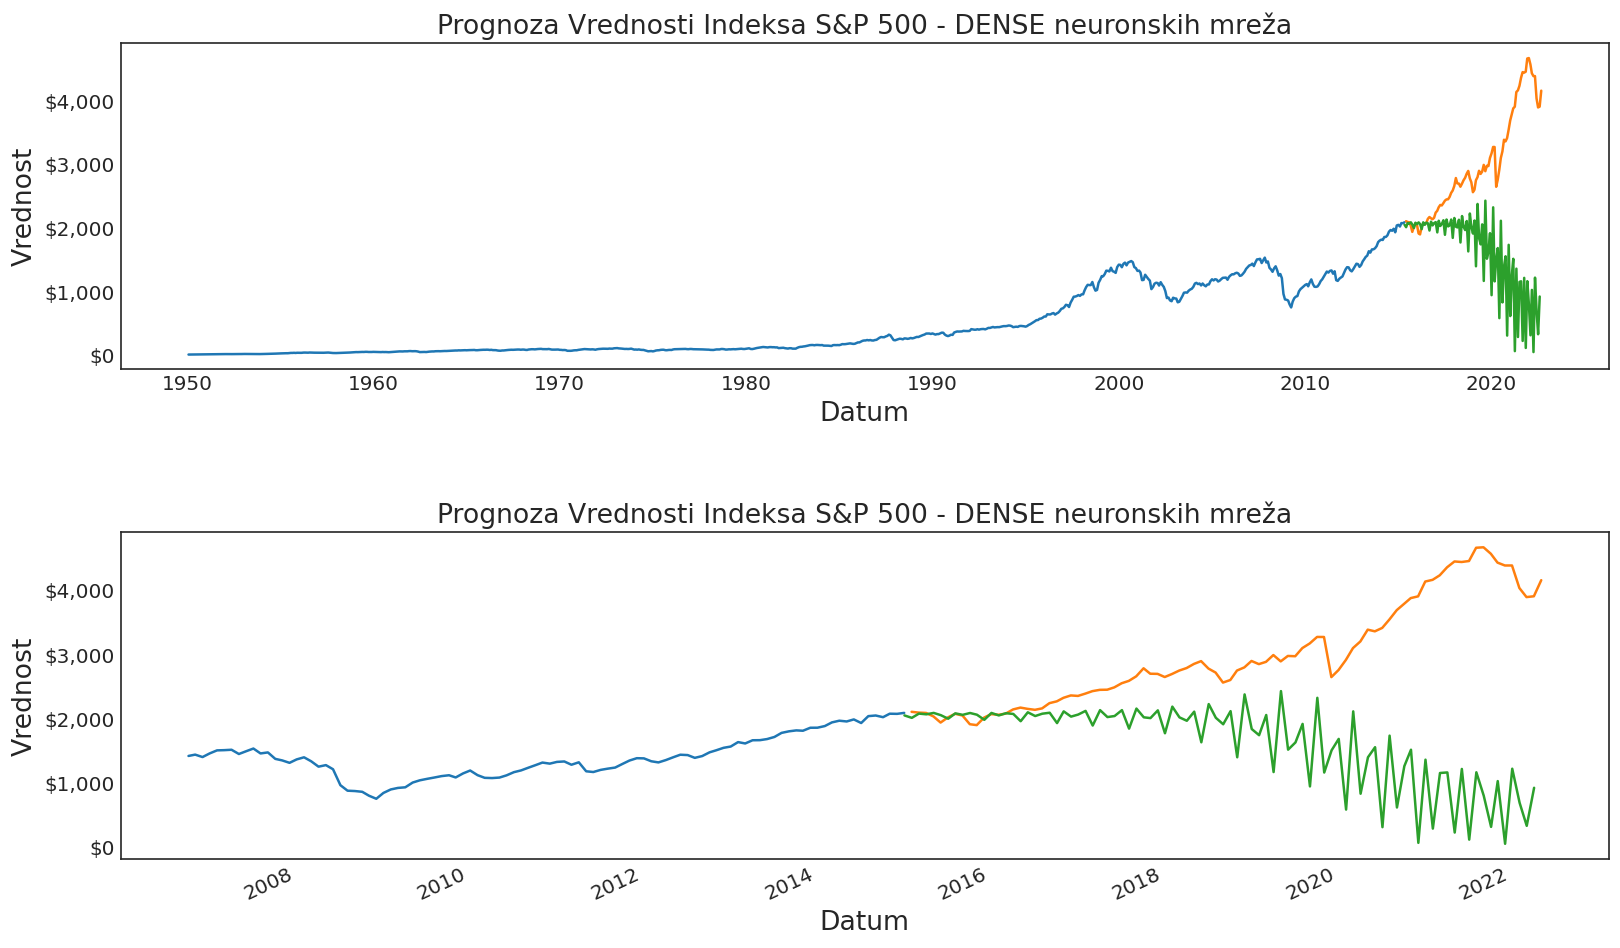

In [ ]:
fig, (ax1, ax2)  = plt.subplots(2,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.5)

ax1.plot(train.index, train.Close, label="Trening")
ax1.plot(test.index, test.Close, label="Test")
ax1.plot(next_time_steps, future_forecast, label="Predikcija")

ax2.plot(train.index[-100:], train.Close[-100:])
ax2.plot(test.index, test.Close)
ax2.plot(next_time_steps, future_forecast)


ax1.set_title("Prognoza Vrednosti Indeksa S&P 500 - DENSE neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("Vrednost")

ax2.set_title("Prognoza Vrednosti Indeksa S&P 500 - DENSE neuronskih mreža")
ax2.set_xlabel("Datum")
ax2.set_ylabel("Vrednost")

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

In [ ]:
mse = mean_squared_error(test, future_forecast)
print('MSE: '+str(mse))

mae = mean_absolute_error(test, future_forecast)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(test, future_forecast))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(test, future_forecast)
print('MAPE: '+str(mape))

MSE: 3629215.459903155
MAE: 1361.3184025144153
RMSE: 1905.049988820019
MAPE: 0.38050872590824986


### **Peti - ConvD model**

In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), 
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(dataset_all,            
            batch_size=128, 
            epochs=100,
            verbose=0
            )

In [ ]:
INTO_FUTURE = len(test)  

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_4,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [2054.26636297 2028.17850952 2082.19579436 2079.99043968 2094.86283947] -> Prediction: 473.1528625488281

Predicting on: 
 [2028.17850952 2082.19579436 2079.99043968 2094.86283947  473.15286255] -> Prediction: 398.78424072265625

Predicting on: 
 [2082.19579436 2079.99043968 2094.86283947  473.15286255  398.78424072] -> Prediction: 302.876220703125

Predicting on: 
 [2079.99043968 2094.86283947  473.15286255  398.78424072  302.8762207 ] -> Prediction: 208.2670440673828

Predicting on: 
 [2094.86283947  473.15286255  398.78424072  302.8762207   208.26704407] -> Prediction: 204.06890869140625

Predicting on: 
 [473.15286255 398.78424072 302.8762207  208.26704407 204.06890869] -> Prediction: 69.7889175415039

Predicting on: 
 [398.78424072 302.8762207  208.26704407 204.06890869  69.78891754] -> Prediction: 51.19318771362305

Predicting on: 
 [302.8762207  208.26704407 204.06890869  69.78891754  51.19318771] -> Prediction: 37.78230667114258

Predicting on: 
 [208.26704407 

In [ ]:
next_time_steps_s = np.insert(next_time_steps, 0, last_timestep)
future_forecast_s = np.insert(future_forecast, 0, sp500Month.Close[-1])
next_time_steps_s, future_forecast_s

(array(['2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
        '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
        '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
        '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
        '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
        '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
        '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
        '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
        '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
        '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03',
        '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
        '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03',
        '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
        '2021-10', '2021-11', '2021-12

In [ ]:
len(next_time_steps_s), len(future_forecast_s)

(89, 89)

(array([732312., 733042., 733773., 734503., 735234., 735964., 736695.,
        737425., 738156., 738886.]),
 <a list of 10 Text major ticklabel objects>)

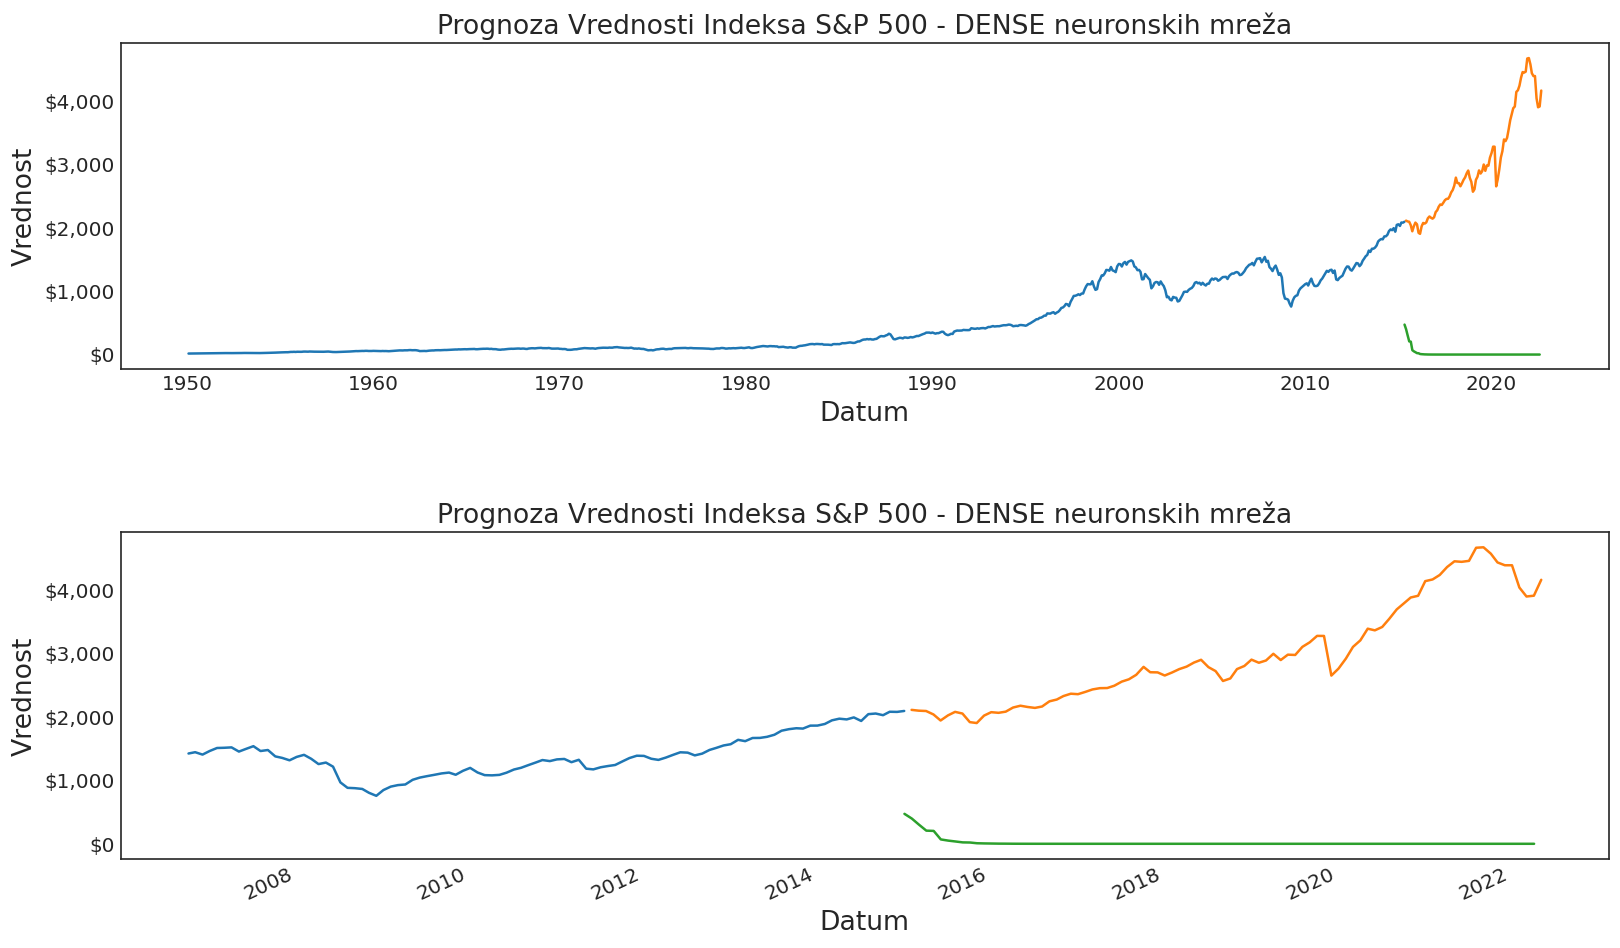

In [ ]:
fig, (ax1, ax2)  = plt.subplots(2,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.5)

ax1.plot(train.index, train.Close, label="Trening")
ax1.plot(test.index, test.Close, label="Test")
ax1.plot(next_time_steps, future_forecast, label="Predikcija")

ax2.plot(train.index[-100:], train.Close[-100:], label="Actual BTC Price")
ax2.plot(test.index, test.Close,   label="Actual BTC Price")
ax2.plot(next_time_steps, future_forecast,  label="Predicted BTC Price")


ax1.set_title("Prognoza Vrednosti Indeksa S&P 500 - DENSE neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("Vrednost")

ax2.set_title("Prognoza Vrednosti Indeksa S&P 500 - DENSE neuronskih mreža")
ax2.set_xlabel("Datum")
ax2.set_ylabel("Vrednost")

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

In [ ]:
mse = mean_squared_error(test, future_forecast)
print('MSE: '+str(mse))

mae = mean_absolute_error(test, future_forecast)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(test, future_forecast))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(test, future_forecast)
print('MAPE: '+str(mape))

MSE: 9452308.680998944
MAE: 2960.8965255720286
RMSE: 3074.4607138486813
MAPE: 0.9897168429667879


### **Šesti model**

In [ ]:
https://github.com/LearnPythonWithRune/MachineLearningWithPython/blob/main/jupyter/final/10%20-%20Lesson%20-%20Recurrent%20Neural%20Network.ipynb

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Lambda, Input

In [ ]:
sp500MonthTraining = pd.DataFrame(sp500Month)
sp500Month = pd.DataFrame(sp500Month)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

sp500_prices_windowed = sp500Month.copy()

for i in range(WINDOW_SIZE): 
  sp500_prices_windowed[f"Price+{i+1}"] = sp500Month["Close"].shift(periods=i+1)

sp500_prices_windowed.head(10)

In [ ]:
X_all = sp500_prices_windowed.drop(["Close"], axis=1).dropna().to_numpy()
y_all = sp500_prices_windowed.dropna()["Close"].to_numpy()

In [ ]:
scaler = MinMaxScaler()
X_all_scaled = scaler.fit_transform(X_all.reshape(-1, 1))
y_all_scaled = scaler.fit_transform(y_all.reshape(-1, 1))

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all_scaled)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all_scaled)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024 
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [ ]:
inputs = Input(shape=(WINDOW_SIZE))
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
x = LSTM(45, activation="relu", return_sequences=True)(x) 
x = LSTM(45, activation="relu")(x) 
x = Dense(32, activation="relu")(x)

output = Dense(HORIZON)(x)

model_lstm_2 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_lstm_2.compile(optimizer='adam', loss='mse')

num_epochs = 10
model_lstm_2.fit(dataset_all, epochs=num_epochs, verbose=1)

In [ ]:
INTO_FUTURE = len(test)   

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_lstm,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
next_time_steps_s = np.insert(next_time_steps, 0, last_timestep)
future_forecast_s = np.insert(future_forecast, 0, sp500Month.Close[-1])
next_time_steps_s, future_forecast_s

In [ ]:
len(next_time_steps_s), len(future_forecast_s)

(89, 89)

(array([732312., 733042., 733773., 734503., 735234., 735964., 736695.,
        737425., 738156., 738886.]),
 <a list of 10 Text major ticklabel objects>)

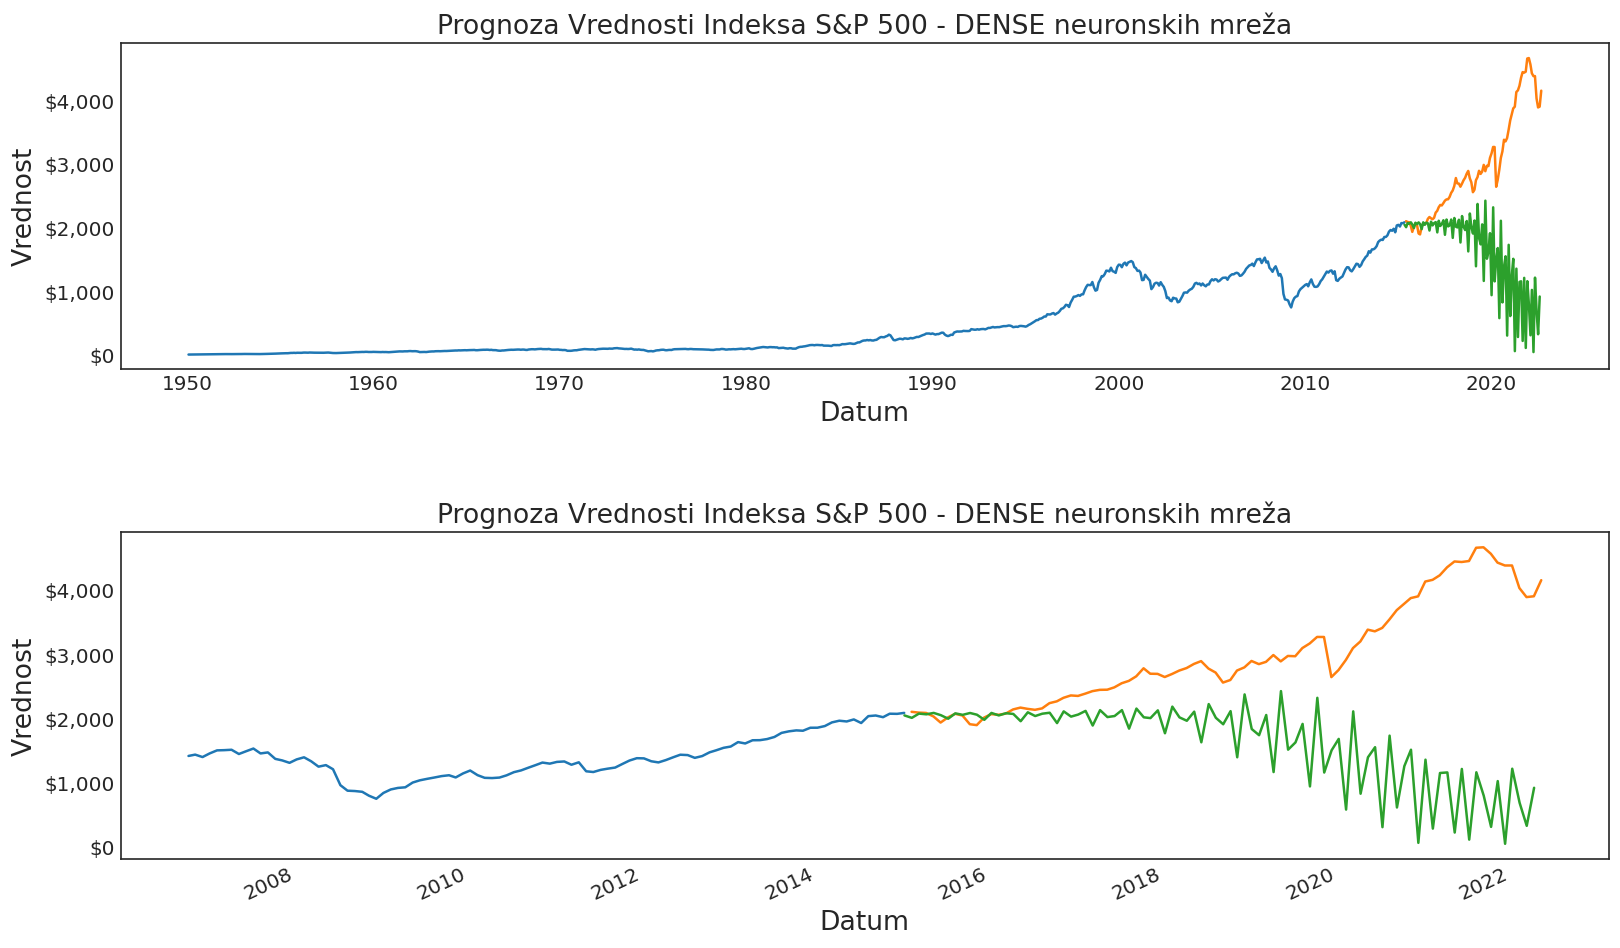

In [ ]:
fig, (ax1, ax2)  = plt.subplots(2,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.5)

ax1.plot(train.index, train.Close, label="Trening")
ax1.plot(test.index, test.Close, label="Test")
ax1.plot(next_time_steps, future_forecast, label="Predikcija")

ax2.plot(train.index[-100:], train.Close[-100:], label="Actual BTC Price")
ax2.plot(test.index, test.Close,   label="Actual BTC Price")
ax2.plot(next_time_steps, future_forecast,  label="Predicted BTC Price")


ax1.set_title("Prognoza Vrednosti Indeksa S&P 500 - LSTM neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("Vrednost")

ax2.set_title("Prognoza Vrednosti Indeksa S&P 500 - LSTM neuronskih mreža")
ax2.set_xlabel("Datum")
ax2.set_ylabel("Vrednost")

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

In [ ]:
mse = mean_squared_error(test, future_forecast)
print('MSE: '+str(mse))

mae = mean_absolute_error(test, future_forecast)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(test, future_forecast))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(test, future_forecast)
print('MAPE: '+str(mape))

MSE: 3629215.459903155
MAE: 1361.3184025144153
RMSE: 1905.049988820019
MAPE: 0.38050872590824986
